# tsam - Animation of pareto-optimal aggregation
Date: 02.05.2022

Author: Leander Kotzur

Import pandas and the relevant time series aggregation class

In [1]:
%load_ext autoreload
%autoreload 2
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt
import tsam.timeseriesaggregation as tsam
import tsam.hyperparametertuning as tune
import tqdm
import numpy as np
from matplotlib.animation import FuncAnimation
%matplotlib inline
import matplotlib
import subprocess
import multiprocessing
import math
matplotlib.rcParams['animation.embed_limit'] = 1000 

### Input data 

Read in time series from testdata.csv with pandas

In [2]:
raw = pd.read_csv('testdata.csv', index_col = 0)
raw=raw.rename(columns={'T': 'Temperature [°C]', 'Load':'Demand [kW]', 'Wind':'Wind [m/s]', 'GHI': 'Solar [W/m²]'})

Setup the hyperparameter instance

In [3]:
tunedAggregations = tune.HyperTunedAggregations(
    tsam.TimeSeriesAggregation(
        raw,
        hoursPerPeriod=24,
        clusterMethod="hierarchical",
        representationMethod="medoidRepresentation",
        rescaleClusterPeriods=False,
        segmentation=True,
    )
)

Load the resulting combination

In [4]:
results = pd.read_csv(os.path.join("results","paretoOptimalAggregation.csv"),index_col=0)
results["time_steps"] = results["segments"] * results["periods"]

## Create the animated aggregations

Drop all results with timesteps below 1% of the original data set since they are not meaningful.

In [6]:
results = results[results["time_steps"]>80]

Append the original time series

In [8]:
results=results.append({"segments":24, "periods":365, "time_steps":len(raw)}, ignore_index=True)

And reverse the order

In [9]:
results=results.iloc[::-1]

And create a dictionary with all aggregations we want to show in the animation

In [10]:
animation_list = []
for i, index in enumerate(tqdm.tqdm(results.index)):
    segments = results.loc[index,:].to_dict()["segments"]
    periods = results.loc[index,:].to_dict()["periods"]
    # aggregate to the selected set
    tunedAggregations._testAggregation(noTypicalPeriods=periods, noSegments=segments)
    # and repredict the data
    prediction = tunedAggregations.aggregationHistory[-1].predictOriginalData()
    # relative reduction of time steps
    reduction = 1 -  ( float(tunedAggregations._segmentHistory[-1] * tunedAggregations._periodHistory[-1]) /len(raw))

    # add a change layer which shows the difference of the latest aggregation to the previous
    if i > 0:
        # difference
        diff_val = previouspredictedPeriods - prediction
        # all fields that changed
        diff_bool = abs(diff_val)>1e-10
        # make sure that when any change is there it gets set to Nan
        prediction_diff = copy.deepcopy(prediction)
        prediction_diff[diff_bool.max(axis=1)] = np.nan

        # what changes ? segments or periods
        if segments == animation_list[-1]["Segments"]:
            misc = "Clustering periods"
        else:
            misc = "Clustering segments"

        animation_list.append({
            "Prediction": prediction_diff,
            "Segments": segments,
            "Periods": periods,
            "Reduction": reduction,
            "Misc": "Medoid representation",#misc,
        })


    animation_list.append({
        "Prediction": prediction,
        "Segments": segments,
        "Periods": periods,
        "Reduction": reduction,
        "Misc": "Medoid representation",
    })

    # and set previous prediction preiods
    previouspredictedPeriods = prediction


100%|██████████| 372/372 [11:23<00:00,  1.84s/it]


And then append a last aggregation with the novel duration/distribution represenation

In [11]:
aggregation=tsam.TimeSeriesAggregation(
        raw,
        hoursPerPeriod=24,
        noSegments=segments,
        noTypicalPeriods=periods,
        clusterMethod="hierarchical",
        rescaleClusterPeriods=False,
        segmentation=True,
        representationMethod="durationRepresentation",
        distributionPeriodWise=False
    )
    
animation_list.append({
        "Prediction": aggregation.predictOriginalData(),
        "Segments": segments,
        "Periods": periods,
        "Reduction": reduction,
        "Misc": "Distribution representation",
    })

## Create the animation

Let animation warp - slow in the beginning and slow in the end

In [ ]:
iterator = []

for i in range(len(animation_list )):
    if i < 1:
        iterator+=[i]*100
    elif i < 3:
        iterator+=[i]*50
    elif i < 6:
        iterator+=[i]*30
    elif i < 20:
        iterator+=[i]*10
    elif i >= len(animation_list )-1:
        iterator+=[i]*150
    elif i > len(animation_list )-3:
        iterator+=[i]*50
    elif i > len(animation_list )-6:
        iterator+=[i]*30
    else:
        iterator+=[i]

Create the plot and the animation loop

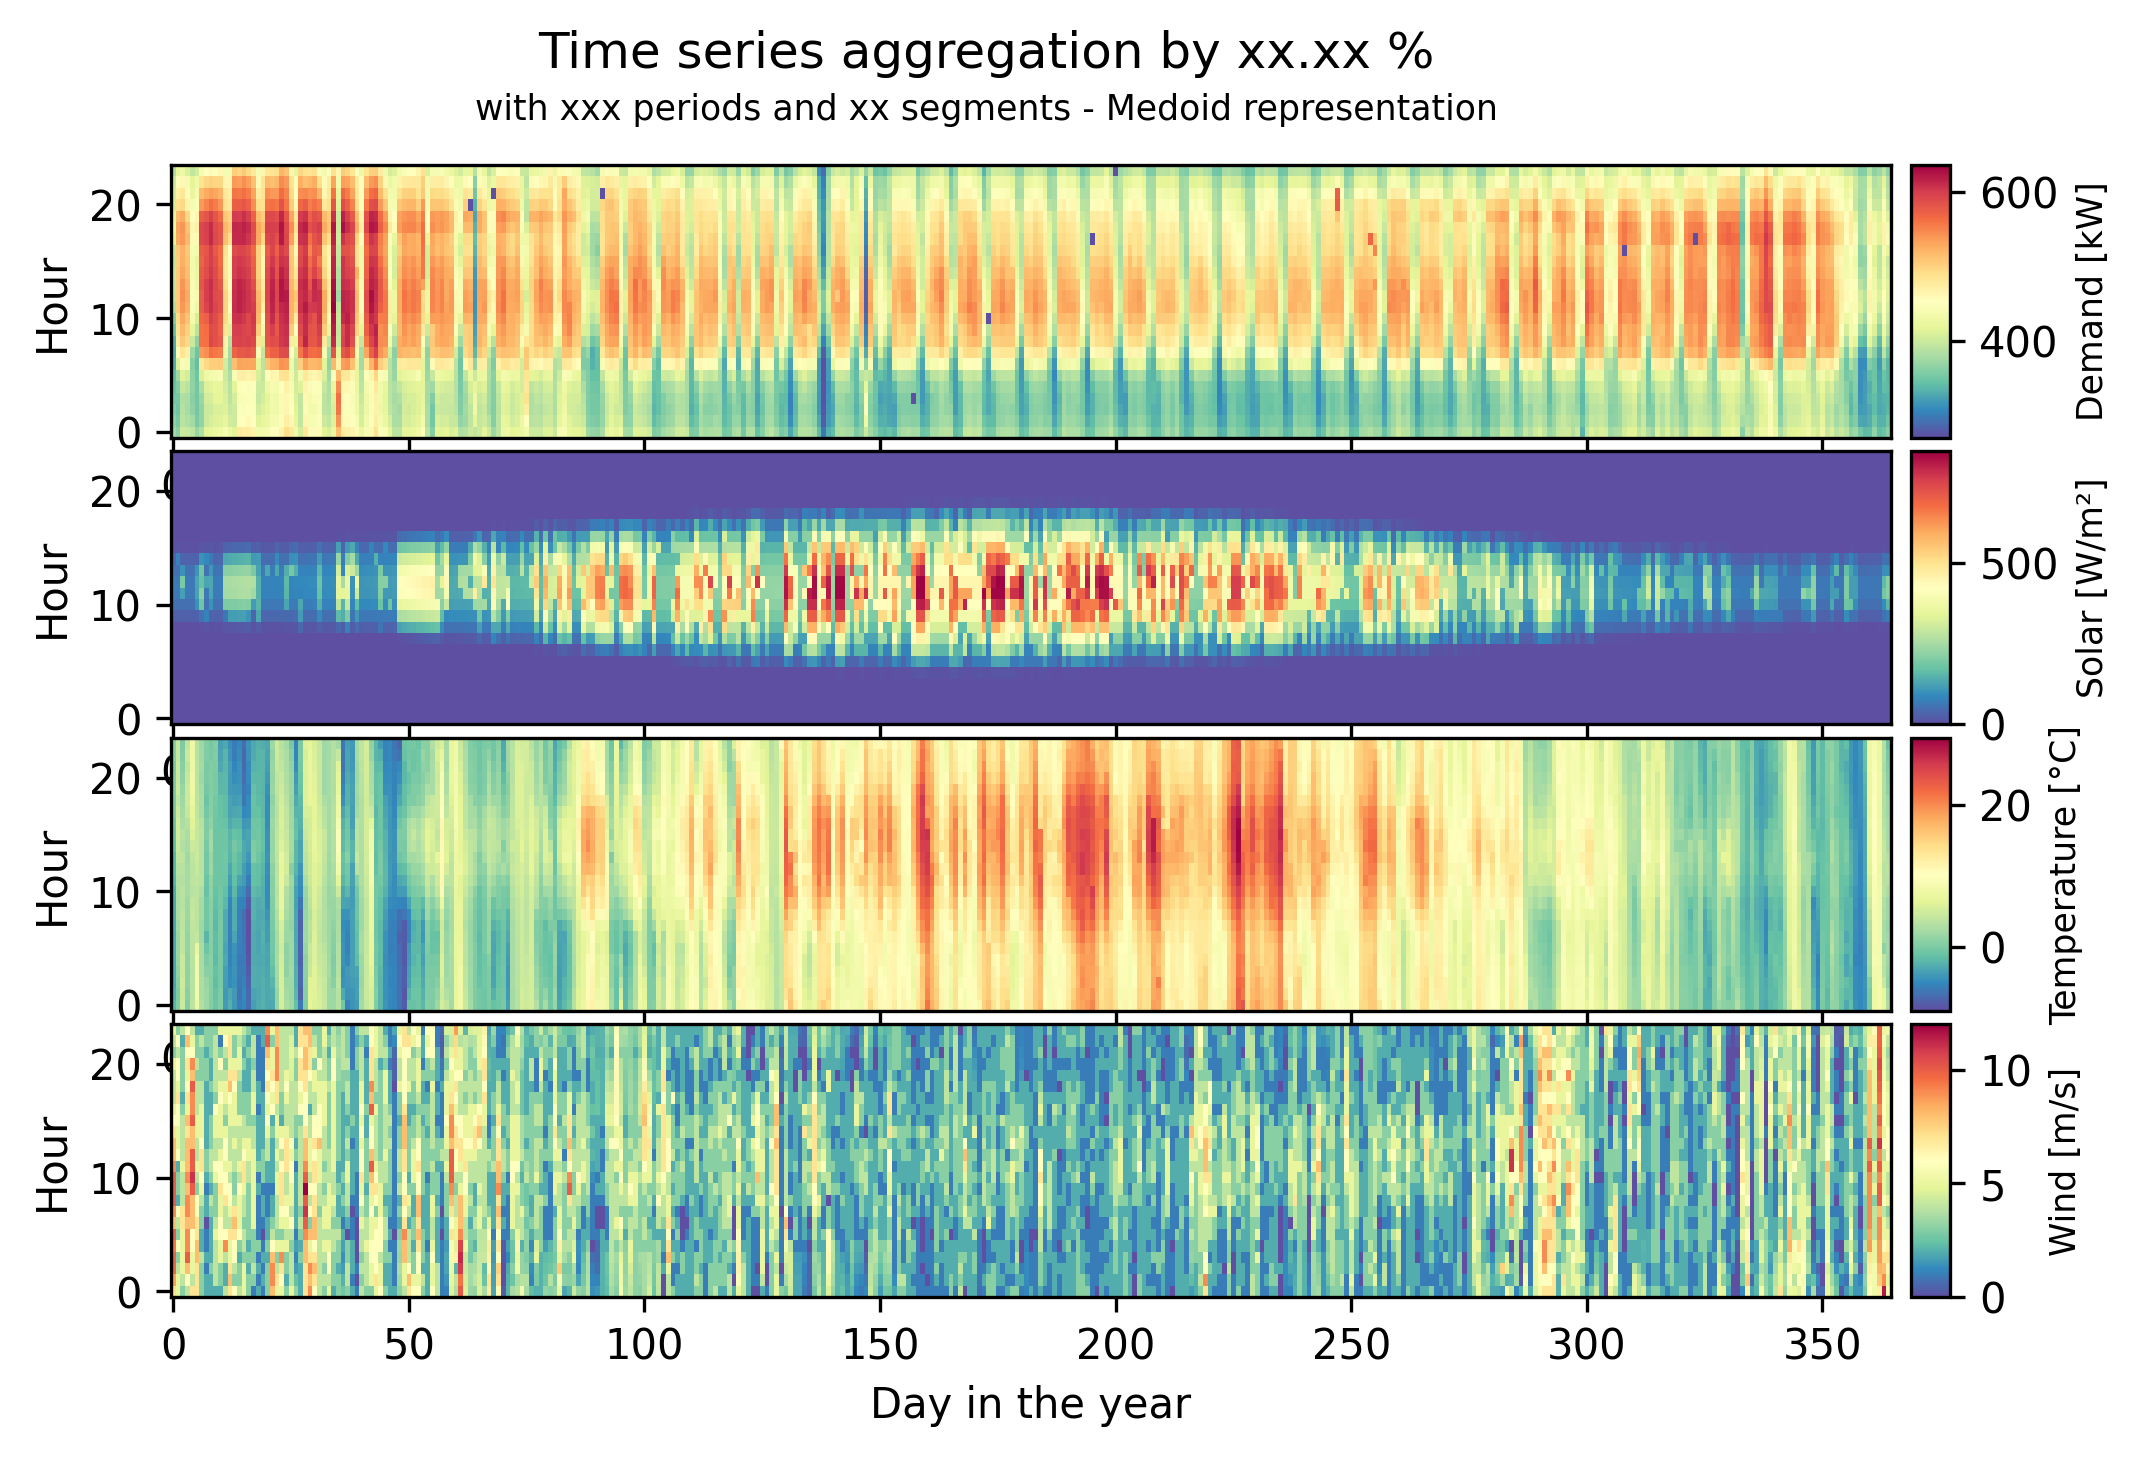

In [47]:
import matplotlib.ticker as tick
fig, axes = plt.subplots(figsize = [7, 5], dpi = 300, nrows = raw.shape[1], ncols = 1)
cmap = plt.cm.get_cmap("Spectral_r").copy()
cmap.set_bad((.7, .7, .7, 1))
for ii, column in enumerate(raw.columns):
    data = raw[column]
    stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(data), tunedAggregations.base_aggregation.hoursPerPeriod)
    cax = axes[ii].imshow(stacked.values.T, interpolation = 'nearest', vmin = raw[column].min(), vmax = raw[column].max(), origin='lower', cmap = cmap)
    axes[ii].set_aspect('auto')  
    axes[ii].set_ylabel('Hour')
    plt.xlabel('Day in the year')
    cbar=plt.colorbar(cax, ax=axes[ii], pad=0.01, aspect=7)
    cbar.set_label(column, fontsize="small")

fig.suptitle('Time series aggregation by xx.xx %',
    y=0.97,
    x=0.3,
    horizontalalignment="left",)
text=fig.text(
        0.27,
        0.91,
        "with xxx periods and xx segments - Medoid representation",
        horizontalalignment="left",
        fontsize="small",)
fig.subplots_adjust(right = 1.1, hspace = 0.05)

def animate(iter):
    i=iterator[iter]
    predictedPeriods = animation_list[i]["Prediction"]
    fig.suptitle(
        'Time series aggregation by ' + str(round(animation_list[i]["Reduction"]*100,2)) + " % ",
        y=0.97,
        x=0.3,
        horizontalalignment="left",)
    text.set_text(
        "with " + 
        str(animation_list[i]["Periods"]) + " periods and " + str(animation_list[i]["Segments"]) + " segments - " + animation_list[i]["Misc"],
        )
    for ii, column in enumerate(raw.columns):
        data = predictedPeriods[column]        
        stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(data), tunedAggregations.base_aggregation.hoursPerPeriod)
        cax = axes[ii].imshow(stacked.values.T, interpolation = 'nearest', vmin = raw[column].min(), vmax = raw[column].max(), origin='lower', cmap = cmap)
        axes[ii].set_aspect('auto')  
    fig.subplots_adjust(right = 1.0, hspace = 0.05)


ani = FuncAnimation(fig, animate, repeat_delay=600, interval=20, frames=len(iterator) )

And save as animation parelllized with ffmpeg since the default matplotlib implemenation takes too long. Faster implemntation than matplotib from here: https://stackoverflow.com/a/31315362/3253411 

Parallelize animation to video

In [49]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [50]:
threads = multiprocessing.cpu_count()
frames=[i for i in range(len(iterator))]

# divide the frame equally
i_length=math.ceil(len(frames)/(threads))
frame_sets=list(chunks(frames,i_length))

filenames=[]
for i in range(len(frame_sets)):
    filenames.append("_temp_video_chunk_" + str(i) + ".mp4")

In [52]:
def ani_to_mp4(frame_range, filename):
    canvas_width, canvas_height = fig.canvas.get_width_height()

    # Open an ffmpeg process
    outf = os.path.join("results", filename)
    cmdstring = ('ffmpeg', 
                    '-y', '-r', '100', # fps
                    '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                    '-pix_fmt', 'argb', # formats
                    '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                    '-vcodec', 'mpeg4', outf) # output encoding
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

    # Draw frames and write to the pipe
    for frame in frame_range:
        # draw the frame
        animate(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()

        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

In [53]:
with multiprocessing.Pool() as pool:
    pool.starmap(ani_to_mp4, zip(frame_sets, filenames))

ffmpeg version 4.4.1-3ubuntu5 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-18ubuntu1)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --ena

In [54]:
filename_list=os.path.join("results", "filenames.txt")
with open(filename_list, "w") as textfile:
    for filename in filenames:
        textfile.write("file '" + filename + "'\n")

In [55]:
cmdstring = ('ffmpeg', '-y',
                '-f', 'concat', 
                '-safe', '0', 
                '-i', filename_list,
                '-c', 'copy', 
                os.path.join("results", "animation.mp4") # output encoding
p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

ffmpeg version 4.4.1-3ubuntu5 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-18ubuntu1)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --ena

You can also show it inline but it takes quite long.

In [ ]:
from IPython.display import HTML
HTML(ani.to_jshtml())